## Packages

In [32]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader 
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.io import read_image
import torchvision
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR, StepLR
import torchvision.transforms as T
from torch.autograd import Variable
from facenet_pytorch import InceptionResnetV1
from torchvision import models
from torch.utils.tensorboard import SummaryWriter

import sklearn.metrics as metrics

## Constants

In [51]:
BATCH_SIZE = 64
BATCH_SIZE_LOGISTIC = 1
N_EPOCHS =1000
FEATURE_EXTRACT = True
PATH = r'..\results\vgg_finetuning'

In [3]:
path_train = r'..\data\data_model\train'
path_test = r'..\data\data_model\test'
path_validation = r'..\data\data_model\val'

## Loss Function

In [4]:
def triplet_loss(x_p, x_n, x_a, margin):
    """calculates triplet loss 

    Args:
      x_p: positive vector
      x_n: negative vector
      x_a: anchor vector
    """
    
    dist_pa = torch.pow(torch.nn.functional.pairwise_distance(x_p, x_a), 2)
    dist_na = torch.pow(torch.nn.functional.pairwise_distance(x_n, x_a), 2)
    
    return torch.mean(torch.clamp(dist_pa - dist_na + margin, min=0.0)) 

In [5]:
# Clamps all elements in input into the range [ min, max ]. 
# Letting min_value and max_value be min and max, respectively, this returns:

# triplet_loss resutrns the mean loss for a batch

## Datasets and Dataloaders

In [6]:
#here we apply data aougmantation and scaling for images
transform_train = T.Compose([
      T.Resize((160, 160)),

    T.ColorJitter(brightness=[1,1.7], contrast=[1,1.7], saturation=0, hue=0),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    T.RandomErasing(),

])

In [7]:
transform_test = T.Compose([
      T.Resize((160, 160)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),

])

In [8]:
# We don't apply augmentation to testing data

In [9]:
# RandomErasing erases pixels in a random ractangle
# Possible solution for glasses and beard

In [83]:
# Does not distinguish glasses
# Possible solutions PA-GAN
# Generate new images of each person with glasses, beard ...
# random crop

In [10]:
class DatasetSiamese(Dataset):

    def __init__(self, img_dir, transform=None, train = True):
        self.img_dir = img_dir
        self.transform = transform
        self.train = train

    def __len__(self):
        return BATCH_SIZE*10

    def __getitem__(self, idx):
        l = random.sample(os.listdir(self.img_dir), 2)
        folder1=os.path.join(self.img_dir, l[0])
        folder2=os.path.join(self.img_dir, l[1])
        
        f1=os.listdir(folder1)
        anchor = random.choice(f1)
        f1.remove(anchor)
        positive = random.choice(f1)
        negative = random.choice(os.listdir(folder2))
        
        path_a = os.path.join(folder1, anchor)
        path_p = os.path.join(folder1, positive)
        path_n = os.path.join(folder2, negative)
        
        label_p = os.path.basename(folder1)
        label_n = os.path.basename(folder2)
        
        image_a = Image.open(os.path.join(folder1, anchor)).convert('RGB')
        image_p = Image.open(os.path.join(folder1, positive)).convert('RGB')
        image_n = Image.open(os.path.join(folder2, negative)).convert('RGB')

                             
        if self.transform is not None:
            image_a = self.transform(image_a)
            image_p = self.transform(image_p)
            image_n = self.transform(image_n)
        
        if self.train:
            return image_a, image_p, image_n 
        else:
            return image_a, image_p, image_n, path_a, path_p, path_n, label_p, label_n 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


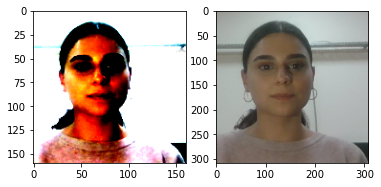

In [11]:
img_path_marie = r'..\data\photos\Marie\8.jpg'

img_marie = Image.open(img_path_marie)

img_normalized_marie = transform_train(img_marie)
 
# convert this image to numpy array
img_normalized_marie = np.array(img_normalized_marie)
 
# transpose from shape of (3,,) to shape of (,,3)
img_normalized_marie = img_normalized_marie.transpose(1, 2, 0)
 
# display the normalized image

f, axarr = plt.subplots(1, 2)
axarr[0].imshow(img_normalized_marie)
axarr[1].imshow(img_marie)

In [12]:
# Datasets for training, testing and validation

In [13]:
dataset_train = DatasetSiamese(path_train, transform = transform_train)
train_loader = DataLoader(dataset_train,shuffle=False,batch_size=BATCH_SIZE)

dataset_test = DatasetSiamese(path_test,transform=transform_test, train=False)
test_loader = DataLoader(dataset_test,shuffle=False,batch_size=BATCH_SIZE)

dataset_valid = DatasetSiamese(path_validation,transform=transform_test, train=False)
valid_loader = DataLoader(dataset_valid,shuffle=False,batch_size=BATCH_SIZE)

In [14]:
len(dataset_train)

640

In [66]:
dataset_valid_logistic = DatasetSiamese(path_validation,transform=transform_test, train=False)
valid_loader_logistic = DataLoader(dataset_valid_logistic,shuffle=False,batch_size=1)

dataset_train_logistic = DatasetSiamese(path_train,transform=transform_train, train=True)
train_loader_logistic = DataLoader(dataset_train_logistic,shuffle=False,batch_size=1)

In [27]:
def mean_std_image(dataiter):
    """Find average and standard deviation of pixels in one batch

    Args:
      dataiter: data batch
    """
    mean_list = []
    std_list = []
    for i in range(len(dataiter)):
        for j in dataiter[i]:
            mean, std = j.mean([1,2]), j.std([1,2])
            mean_list.append(mean)
            std_list.append(std)
    return sum(mean_list)/len(mean_list), sum(std_list)/len(std_list) 

In [32]:
dataiter[0].shape

torch.Size([64, 3, 160, 160])

In [28]:
dataiter = next(iter(train_loader))
print('length:', len(dataset_train))
print('items in batch:', len(dataiter))

length: 640
items in batch: 3


In [67]:
mean_std_image(dataiter)
# mean and std of channels in one batch
# recommended [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
# already normalized

(tensor([0.5405, 0.3141, 0.6520]), tensor([1.1756, 1.3122, 1.2321]))

In [45]:
N_BATCHES = len(dataset_train)/BATCH_SIZE

## Plotting Functions

In [15]:
def show_image(img, figsize=(20, 20)):
    """Plottes an image with a given figsize

    Args:
      img: image
      figsize: show image size
    """
    img = np.array(img)
    d = img.transpose(1, 2, 0)
    plt.figure(figsize=figsize)
    plt.imshow(d)
    plt.show()

In [60]:
def plot_distances(dataiter):
    """Plottes the anchor, positive and negative images and the distances between output vectors

    Args:
      dataiter: data batch
    """
    for idx in range(BATCH_SIZE):
        image_a = Image.open(dataiter[3][idx])
        image_p = Image.open(dataiter[4][idx])
        image_n = Image.open(dataiter[5][idx])

        vec_a, vec_p, vec_n = model(dataiter[0], dataiter[1], dataiter[2])
        
         
        dist_ap = torch.nn.functional.pairwise_distance(vec_a[idx], vec_p[idx])
        dist_an = torch.nn.functional.pairwise_distance(vec_a[idx], vec_n[idx])

        f, axarr = plt.subplots(1, 3)
        axarr[0].imshow(image_a)
        axarr[1].imshow(image_p)
        axarr[2].imshow(image_n)

        plt.text(600, 100, f'{dataiter[6][idx]}, {dataiter[6][idx]}, {dataiter[7][idx]}\n similarity score : {dist_ap}\n dissimilarity score {dist_an}\n ', horizontalalignment='center',
     verticalalignment='center', fontsize = 12,  bbox = dict(facecolor = 'white', alpha = 1))
        plt.show()

In [1]:
def plot_logistic(X, y, y_pred):
    """Plottes the logistic regression curve

    Args:
      X: distances of vectors
      y: target
      y_pred: predicted target
    """
    plt.figure(1, figsize=(10, 5))
    plt.clf()
    plt.scatter(X.ravel(), y)
    plt.plot(X, y_pred[:, 1], color='red')
    plt.show()

In [19]:
def resize_img(img_dir, newsize):
    """Resizes an image to a given size

    Args:
      img_dir: directory of images
      newsize: new size of an image
    """
    transform =torchvision.transforms.Resize(newsize)
    for directory in os.listdir(img_dir):
        directory=os.path.join(img_dir, directory)
        for img in os.listdir(directory):                        
            im = Image.open(os.path.join(directory, img))
            im=transform(im)
            im.save(os.path.join(directory, img), 'PNG', quality=90)

In [50]:
def plot_loss(train_list, validation_list, figsize):
    """Plot losses during train and validation

    Args:
      train_list: array of train losses based on epoch
      validation_list: array of validation losses based on epoch
      figsize: size of the plot
    """
    plt.figure(figsize = figsize)

    plt.title("Loss of CRNN")
    plt.plot(train_list, label="Train Loss")
    plt.plot(validation_list, label = "Validation Los")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

## Metrics

In [20]:
def calculate_metric(x_a, x_p, x_n):
    """Calculates the accuracy of predictions
    
    Args:
        x_a: output vectors of anchor images
        x_p: output vectors of positive images
        x_n: output vectors of negative images
    """
    dist_p = torch.pow(torch.nn.functional.pairwise_distance(x_p, x_a), 2)
    dist_n = torch.pow(torch.nn.functional.pairwise_distance(x_n, x_a), 2)
    
    a =  dist_p < dist_n
    z = a.unique(return_counts=True)
    if True in z[0]:
        index = (z[0] == True).nonzero(as_tuple=True)[0].item()
        acc = z[1][index]/len(a)
    else:
        acc = 0
    return acc


## Visualizing the dataset

In [26]:
dataiter = next(iter(train_loader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


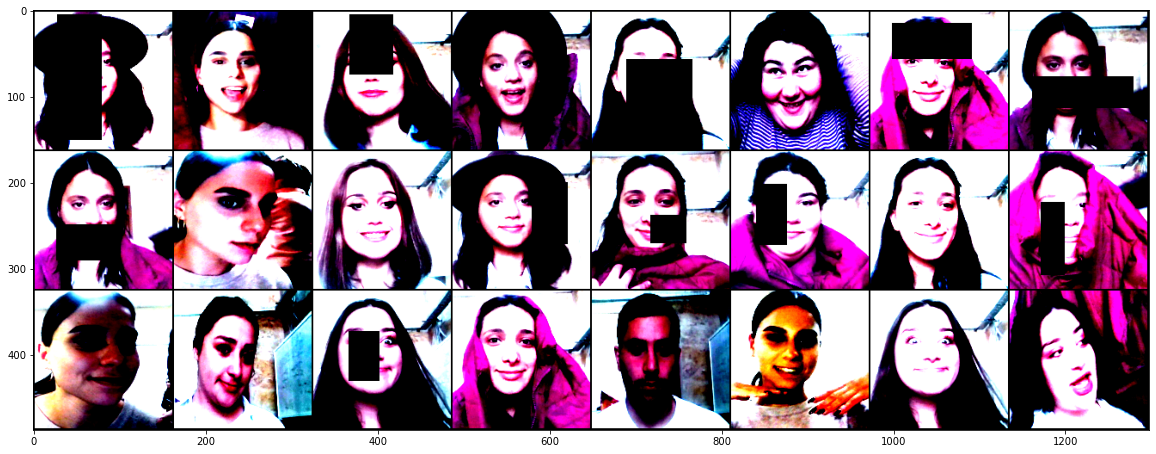

In [27]:
concatenated = torch.cat((dataiter[0][:8], dataiter[1][:8],dataiter[2][:8]),0)
show_image(torchvision.utils.make_grid(concatenated))

## Modeling

In [28]:
# model inception v1
class SiameseFaceRecognition(nn.Module):

    def __init__(self):
        super(SiameseFaceRecognition, self).__init__()
        resnet_custom = InceptionResnetV1(pretrained='vggface2').eval()
        
        # Freeze some part of model weights
        i=0
        for param in resnet_custom.parameters():
            i+=1
            if(i<370):
                param.requires_grad = False

        # the number of features of the last fully connected layer
        num_ftrs = resnet_custom.logits.in_features
        # replacing the last fully connected layer    
        resnet_custom.logits = nn.Linear(num_ftrs,128)
        self.model_custom = resnet_custom
        
         
    def forward_once(self, x):
        return self.model_custom(x)
    
    def forward(self, imageA, imageP,imageN = None):
        if imageN is not None:
            resultA = self.forward_once(imageA)
            resultP = self.forward_once(imageP)
            resultN = self.forward_once(imageN)
            return resultA, resultP,resultN
        
        resultA = self.forward_once(imageA)
        resultP = self.forward_once(imageP)             
        return resultA, resultP

In [29]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cpu")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [30]:
model = SiameseFaceRecognition()

#moving to gpu
model.to(device)

print(model)

SiameseFaceRecognition(
  (model_custom): InceptionResnetV1(
    (conv2d_1a): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv2d_2a): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv2d_2b): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2d_3b): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.

In [31]:
optimizer = optim.Adam(model.parameters(), lr=0.00001)
scheduler = StepLR(optimizer, step_size = 10)

In [33]:
for j,data in tqdm(enumerate(train_loader)):
    break

0it [00:00, ?it/s]


In [39]:
data[0].shape

torch.Size([64, 3, 160, 160])

In [44]:
running_train_loss=[]
running_valid_loss=[]
running_train_acc=[]
running_valid_acc=[]
best_loss = float("inf")

    
with torch.no_grad():
    for j,data in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()
        result_a, result_p, result_n = model(data[0].to(device), data[1].to(device), data[2].to(device))

        loss_net = triplet_loss(result_p, result_n, result_a, 1)
        acc_train = calculate_metric(result_a, result_p, result_n)
        
        running_train_loss.append(loss_net.item())
        running_train_acc.append(acc_train.item())
        
        torch.cuda.empty_cache()    


    for j,data in tqdm(enumerate(valid_loader)):

        optimizer.zero_grad()
        result_a, result_p, result_n = model(data[0].to(device), data[1].to(device), data[2].to(device))


        loss_net = triplet_loss(result_p, result_n, result_a, 1)
        acc_valid = calculate_metric(result_a, result_p, result_n)
        
        running_valid_loss.append(loss_net.item())
        running_valid_acc.append(acc_valid.item())

   
    print("="*50)
    print("train loss= "+str(sum(running_train_loss)/len(running_train_loss)))
    print("train acc= "+str(sum(running_train_acc)/len(running_train_acc)))
    
    print("validation loss= "+str(sum(running_valid_loss)/len(running_valid_loss)))
    print("validation acc= "+str(sum(running_valid_acc)/len(running_valid_acc)))

10it [00:36,  3.63s/it]
10it [00:36,  3.68s/it]

train loss= 0.6150414943695068
train acc= 0.765625
validation loss= 0.3706186980009079
validation acc= 0.859375


In [46]:
N_BATCHES = len(dataset_train)/BATCH_SIZE

In [52]:
running_train_loss=0
loss_train=[]
running_valid_loss=0
loss_valid=[]

running_train_acc=0
running_valid_acc=0

best_loss = float("inf")
model.train()

for i in tqdm(range(N_EPOCHS)):
    print('epoch ' + str(i))
    for j,data in enumerate(train_loader):
        optimizer.zero_grad()
        result_a, result_p, result_n = model(data[0].to(device), data[1].to(device), data[2].to(device))
        
        acc_train = calculate_metric(result_a, result_p, result_n)
        loss_net = triplet_loss(result_p, result_n, result_a, 1)
        
        
        loss_net.backward()
        optimizer.step()
        scheduler.step()
        
        running_train_acc += acc_train.item()
        running_train_loss += loss_net.item()
        torch.cuda.empty_cache()
        

    loss_train.append(running_train_loss/N_BATCHES)
      
    with torch.no_grad():
        model.eval()
        for j,data in enumerate(valid_loader):
            
            optimizer.zero_grad()
            result_a, result_p, result_n = model(data[0].to(device), data[1].to(device), data[2].to(device))
            
            acc_valid = calculate_metric(result_a, result_p, result_n)
            loss_net = triplet_loss(result_p, result_n, result_a, 1)
            
            running_valid_loss += loss_net.item()
            running_valid_acc += acc_valid.item()
            
        loss_valid.append(running_valid_loss/N_BATCHES)
        
        if (running_valid_loss/N_BATCHES < best_loss):
            print(f"Loss decresed to {running_valid_loss/N_BATCHES} from {best_loss}")
            best_loss = running_valid_loss/N_BATCHES
            
            torch.save({
            'epoch': i,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss,
            }, PATH)
            
        print("="*50)
        print("train loss= "+str(running_train_loss/N_BATCHES))
        print("train acc= "+str(running_train_acc/N_BATCHES))
        print("validation loss= "+str(running_valid_loss/N_BATCHES))
        print("validation acc= "+str(running_valid_acc/N_BATCHES))
            
        running_valid_loss=0
        running_train_loss=0
        running_train_acc=0
        running_valid_acc=0    
    

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

epoch 0
Loss decresed to 0.3217721149325371 from inf


  0%|                                                                             | 1/1000 [02:29<41:36:24, 149.93s/it]

train loss= 0.24768515974283217
train acc= 0.9265625
validation loss= 0.3217721149325371
validation acc= 0.909375
epoch 1
Loss decresed to 0.3120846152305603 from 0.3217721149325371


  0%|▏                                                                            | 2/1000 [05:01<41:50:51, 150.95s/it]

train loss= 0.2421160399913788
train acc= 0.9296875
validation loss= 0.3120846152305603
validation acc= 0.91875
epoch 2


  0%|▏                                                                            | 3/1000 [07:33<41:52:14, 151.19s/it]

train loss= 0.25322152078151705
train acc= 0.9234375
validation loss= 0.3542954295873642
validation acc= 0.9015625
epoch 3


  0%|▎                                                                            | 4/1000 [10:05<41:59:59, 151.81s/it]

train loss= 0.25987663865089417
train acc= 0.9203125
validation loss= 0.3247600898146629
validation acc= 0.91875
epoch 4
Loss decresed to 0.2982278525829315 from 0.3120846152305603


  0%|▍                                                                            | 5/1000 [12:42<42:29:25, 153.73s/it]

train loss= 0.26039726138114927
train acc= 0.9203125
validation loss= 0.2982278525829315
validation acc= 0.93125
epoch 5


  1%|▍                                                                            | 6/1000 [15:15<42:21:38, 153.42s/it]

train loss= 0.24039899557828903
train acc= 0.9234375
validation loss= 0.30924710631370544
validation acc= 0.9203125
epoch 6


  1%|▌                                                                            | 7/1000 [17:54<42:50:23, 155.31s/it]

train loss= 0.26304711401462555
train acc= 0.925
validation loss= 0.3052993923425674
validation acc= 0.921875
epoch 7


  1%|▌                                                                            | 8/1000 [20:32<42:59:49, 156.04s/it]

train loss= 0.2527932748198509
train acc= 0.9296875
validation loss= 0.31764011085033417
validation acc= 0.9234375
epoch 8


  1%|▋                                                                            | 9/1000 [23:07<42:53:27, 155.81s/it]

train loss= 0.23961392641067505
train acc= 0.9265625
validation loss= 0.33612740635871885
validation acc= 0.909375
epoch 9


  1%|▋                                                                            | 9/1000 [23:31<43:09:53, 156.80s/it]


KeyboardInterrupt: 

In [63]:
resize_img(path_validation, (200, 200))

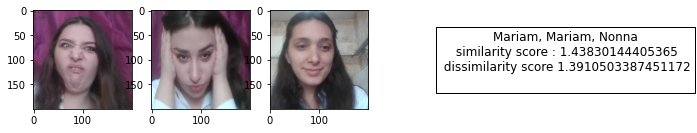

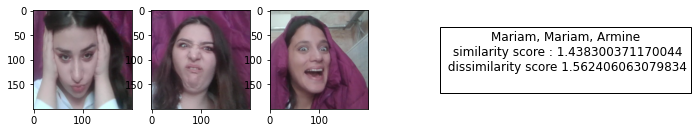

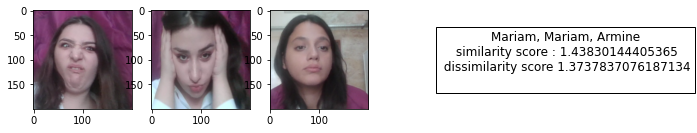

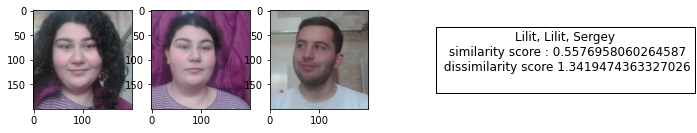

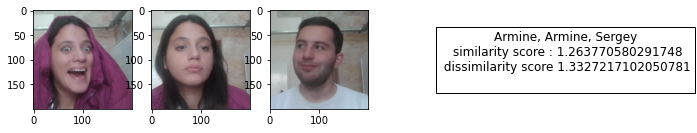

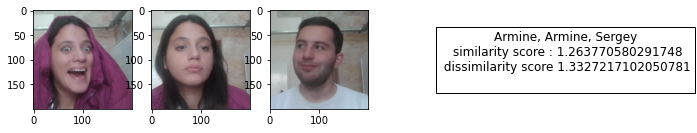

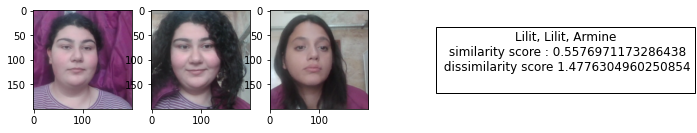

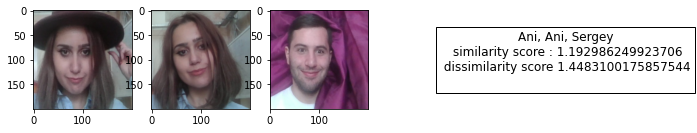

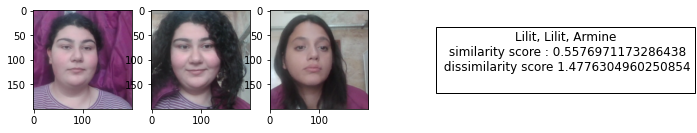

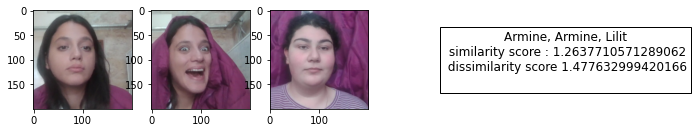

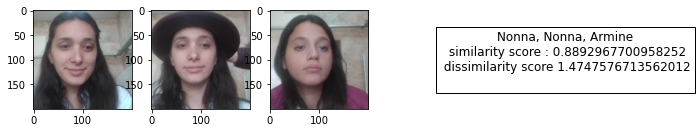

KeyboardInterrupt: 

In [64]:
dataiter = next(iter(valid_loader))
plot_distances(dataiter)

## Calculating Model Scores

In [68]:
res_train = []
for j,data in enumerate(train_loader_logistic):
    
    y_anchor_pred,y_positive_pred,y_negative_pred=model(data[0].to(device), data[1].to(device), data[2].to(device))
    
    dist_ap = torch.nn.functional.pairwise_distance(y_positive_pred, y_anchor_pred)
    dist_an = torch.nn.functional.pairwise_distance(y_negative_pred, y_anchor_pred)
    
    res_train.append((dist_ap.item(), 1))
    res_train.append((dist_an.item(), 0))

In [69]:
res_train.sort()
res_train=np.array(res_train)

X = res_train[:, 0]
y = res_train[:, 1]

from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(random_state = 0, solver='lbfgs')

classifier.fit(X.reshape(-1, 1), y)

y_pred = classifier.predict_proba(X.reshape(-1, 1))

In [70]:
THRESHOLD = 0.5
y_hat = np.where(y_pred[:,1] > THRESHOLD, 1, 0)

In [71]:
unique, counts = np.unique(y_hat, return_counts=True)
print(unique)
print(counts)

[0 1]
[711 569]


In [72]:
print("Accuracy ", metrics.accuracy_score(y, y_hat))
print("AUC ", metrics.roc_auc_score(y, y_pred[:, 1]))

Accuracy  0.89453125
AUC  0.9528979492187502


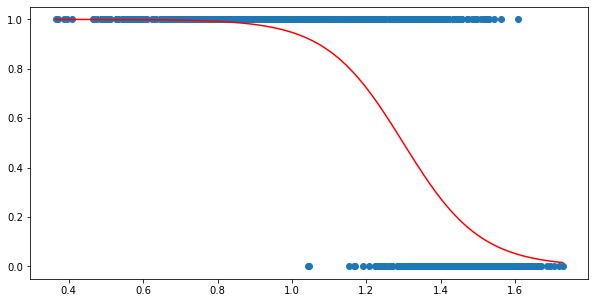

In [73]:
plot_logistic(X, y, y_pred)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


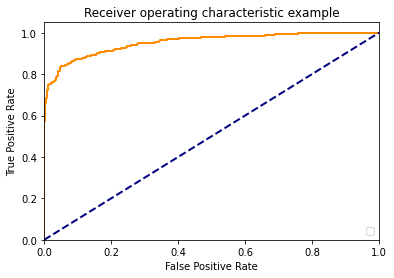

In [74]:
fpr, tpr, thresholds = metrics.roc_curve(y, y_pred[:, 1])
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [76]:
res_valid = []
for j,data in enumerate(valid_loader_logistic):
    
    y_anchor_pred,y_positive_pred,y_negative_pred=model(data[0].to(device),data[1].to(device),data[2].to(device))
 
    dist_ap = torch.nn.functional.pairwise_distance(y_positive_pred, y_anchor_pred)
    dist_an = torch.nn.functional.pairwise_distance(y_negative_pred, y_anchor_pred)
    
    res_valid.append((dist_ap.item(), 1))
    res_valid.append((dist_an.item(), 0))

In [77]:
res_valid.sort()
res_valid=np.array(res_valid)

X = res_valid[:, 0]
y = res_valid[:, 1]

from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(random_state = 0, solver='lbfgs')

classifier.fit(X.reshape(-1, 1), y)

y_pred = classifier.predict_proba(X.reshape(-1, 1))

In [78]:
THRESHOLD = 0.5
y_hat = np.where(y_pred[:,1] > THRESHOLD, 1, 0)

In [79]:
unique, counts = np.unique(y_hat, return_counts=True)
print(unique)
print(counts)

[0 1]
[696 584]


In [80]:
print("Accuracy ", metrics.accuracy_score(y, y_hat))
print("AUC ", metrics.roc_auc_score(y, y_pred[:, 1]))

Accuracy  0.9
AUC  0.9219482421874999


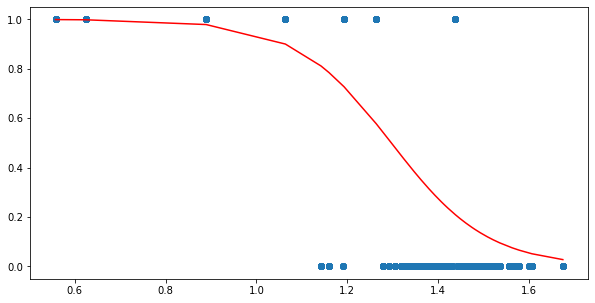

In [81]:
plot_logistic(X, y, y_pred)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


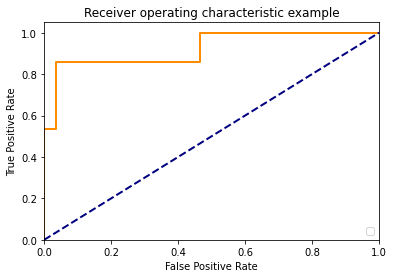

In [82]:
fpr, tpr, thresholds = metrics.roc_curve(y, y_pred[:, 1])
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [60]:
filename = 'finalized_logistic.sav'
joblib.dump(classifier, filename)

['finalized_logistic.sav']